# Precios Historicos del Bitcoin en USD

Esta semana ud estara utilizando la teoria de RNN para realizar la prediccion del precio del Bitcoin.'
Utilice Google Colab para este ejercicio. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data = pd.read_csv(r'C:\Users\XPC\Desktop\Datasets\bitcoin\bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv')
data["date"] = pd.to_datetime(data["Timestamp"],unit="s").dt.date
grupo = data.groupby("date")
data = grupo["Close"].mean()

data.head()

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

### Normalizar datos

In [3]:
series = []
step = 60
series = data.values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

series = np.array(series)
series = series.reshape(series.shape[0],1)
series = scaler.fit_transform(series)
series = series[:,-1] # flatten

series.shape

(3178,)

### Conversion de los datos en tensor 3D de 60 steps c/u

In [4]:
# crear list unica de tamano step

series_50 = []

for i in range(step, series.shape[0] - step): # (50 a 3128), ojo que inicia en index 50
    series_50.append(series[i-step:i]) # series de 50 moviendose 1
    
series_50 = np.array(series_50)
series_50 = series_50[..., np.newaxis].astype(np.float32)

series_50.shape

(3058, 60, 1)

### Crear Train-Test Set

In [5]:
n_steps = 50
x_train, y_train = series_50[:2800, :n_steps], series_50[:2800, -10:, 0]
x_test, y_test = series_50[2800:, :n_steps], series_50[2800:, -10:, 0]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2800, 50, 1) (2800, 10)
(258, 50, 1) (258, 10)


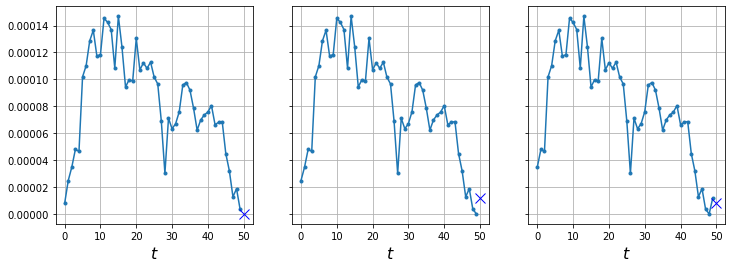

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(x_train[col, :, 0], y_train[col, 0],
                y_label=("" if col==0 else None))
plt.show()

### Entrenar el Modelo

In [7]:
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(70, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(70),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_test, y_test))


Train on 2800 samples, validate on 258 samples
Epoch 1/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 2/20
2800/2800 [==============================] - 3s 999us/step - loss: 0.0014 - val_loss: 0.0021
Epoch 3/20
2800/2800 [==============================] - 3s 999us/step - loss: 0.0013 - val_loss: 0.0037
Epoch 4/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 5/20
2800/2800 [==============================] - 3s 999us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 6/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 7/20
2800/2800 [==============================] - 3s 999us/step - loss: 0.0011 - val_loss: 0.0019
Epoch 8/20
2800/2800 [==============================] - 3s 995us/step - loss: 9.4532e-04 - val_loss: 0.0015
Epoch 9/20
2800/2800 [==============================] - 3s 1000us/step - loss: 9.8378e-04 - val_loss: 0.0035
Epoch 10/20
2

### Curvas de Aprendizaje

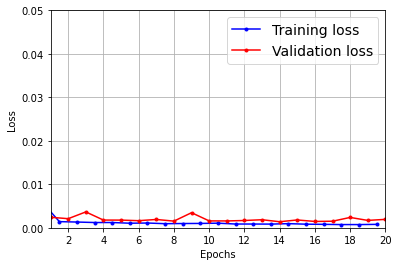

In [8]:
import matplotlib as mpl

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [9]:
y_pred = model.predict(x_test)[..., np.newaxis]

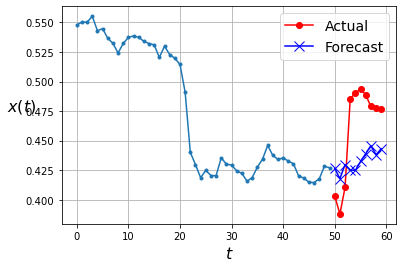

In [10]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.legend(fontsize=14)

plot_multiple_forecasts(x_test, y_test[..., np.newaxis], y_pred)
plt.show()